In [28]:
import numpy as np
inf=float("inf")

import pandas as pd
import matplotlib

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import scipy.stats as st

from scipy.cluster import hierarchy

import stablerank.srank as sr
import stablerank.geometry_objects_2020 as ge

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import _pickle as pickle

from ripser import ripser
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from PIL import Image

import os

#from keras.datasets import mnist
#from matplotlib import pyplot

matplotlib.rc("text", usetex=True)
matplotlib.rc("font", family="serif")

matplotlib.rc("text.latex", preamble=r"""
\usepackage{amsmath,amssymb,amsfonts}
\usepackage{bm}
\DeclareMathOperator{\newdiff}{d} % use \dif instead
\newcommand{\dif}{\newdiff\!} %the correct way to do derivatives
\newcommand{\bigoh}{\mathcal{O}}
\makeatletter
\let\oldabs\abs
\def\abs{\@ifstar{\oldabs}{\oldabs*}}
\newcommand\norm[1]{\left\lVert#1\right\rVert}
""")

In [29]:
# loading the data

df=pd.read_csv('challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv', sep=',')
#df=pd.read_csv('challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv', sep=',',header=None)

In [30]:
# Removing duplicate values and reindexing

df.drop_duplicates(subset =[" pixels"], inplace = True)
df=df.reindex(range(0,len(df)-1))

In [31]:
df

,emotion,Usage,pixels
0,0.0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0.0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2.0,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4.0,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6.0,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
34028,0.0,PrivateTest,157 157 157 157 156 156 155 155 157 155 155 14...
34029,3.0,PrivateTest,24 33 41 48 48 58 75 95 110 139 158 172 178 18...
34030,5.0,PrivateTest,42 70 65 49 34 33 34 39 58 61 86 86 68 93 76 5...
34031,0.0,PrivateTest,49 47 51 60 60 61 66 70 74 74 70 63 65 75 69 6...


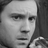

In [32]:
# Printing the first picture
first_picture = [int(numeric_string) for numeric_string in df[" pixels"][0].split(' ')]
first_picture_arr = np.array(first_picture)
first_picture_arr.resize((48,48))
im = Image.fromarray((255-first_picture_arr* 255).astype(np.uint8))
im

In [33]:
#Schmierblatt

pos = np.array(np.where(df["emotion"]==3))[0]
rand_pos = pos[list(np.random.permutation(np.arange(0,len(pos)-1))[:20])]
points_dummy = np.empty((len(rand_pos),48*48), int)

for i in range(0,len(rand_pos)):
    points_dummy[i] = [int(numeric_string) for numeric_string in df[" pixels"][rand_pos[i]].split(' ')]

points = np.vstack(points_dummy)
#df[" pixels"].loc[pos]

In [34]:
angry = sr.EucObject(points)
print("size: ", angry.size)
print("dimension: ", angry.dim)
print("points: ", angry.points)

size:  20
dimension:  2304
points:  [[ 22.  17.  26. ... 255. 255. 255.]
 [ 14.  23.  40. ... 122. 117. 109.]
 [ 30.  35.  46. ...  74.  80.  87.]
 ...
 [199. 187. 183. ...  90. 180. 123.]
 [125.  94.  87. ... 115.  87.  90.]
 [ 54.  56.  55. ...  66.  65.  58.]]


In [35]:
# specifying metric
metric = "minkowski"
metric_parameter = 3

# specifying clustering method
clustering_method = "complete"


f1 = angry.get_h0sr(metric = metric, metric_parameter = metric_parameter)


#plt.figure(figsize=(20,20))

#f1.plot(color ="blue")

# $H_0$ stable rank for embedding 1

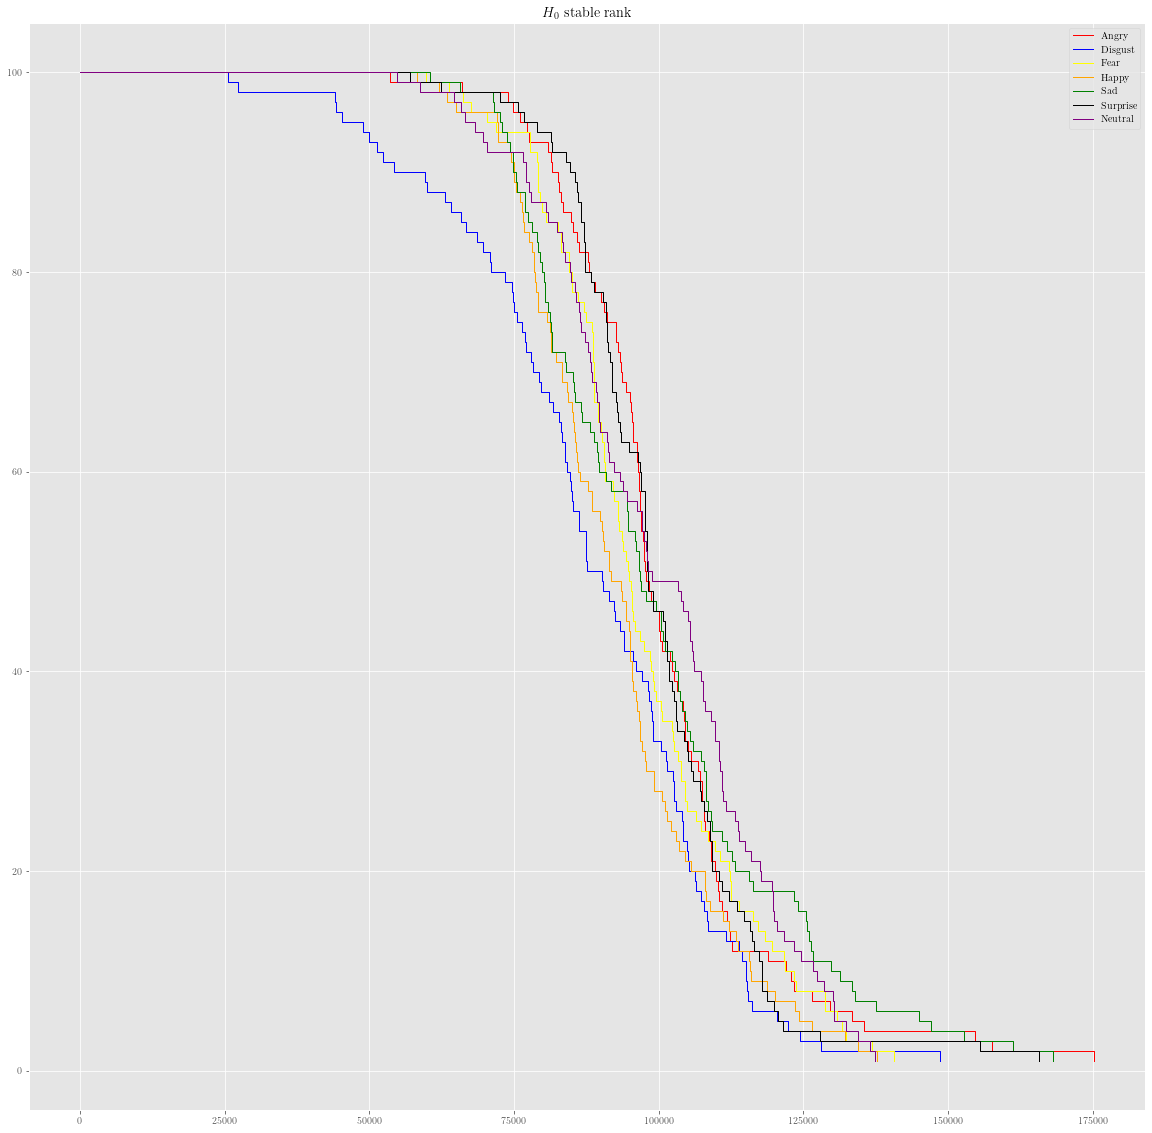

In [65]:
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
emotion_categories = [0,1,2,3,4,5,6]
colours=["red","blue","yellow","orange","green","black","purple"]
legends = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# specifying the number of pictures for subsampling
number_of_pictures = 100

# specifying metric
metric = "cityblock"
metric_parameter = 4

# specifying clustering method
clustering_method = "single"

plt.figure(figsize=(20,20))

for e in emotion_categories:
    pos = np.array(np.where(df["emotion"]==e))[0]
    #rand_pos = pos[np.random.randint(0,len(pos)-1,number_of_pictures)]
    rand_pos = pos[list(np.random.permutation(np.arange(0,len(pos)-1))[:number_of_pictures])]
    points_dummy = np.empty((len(rand_pos),48*48), int)

    for i in range(0,len(rand_pos)):
        points_dummy[i] = [int(numeric_string) for numeric_string in df[" pixels"][rand_pos[i]].split(' ')]

    points = np.vstack(points_dummy)
    
    point_cloud = sr.EucObject(points)
    
    f_pcf = point_cloud.get_h0sr(metric = metric, metric_parameter = metric_parameter)
    
    f_pcf.plot(color=colours[emotion_categories.index(e)])

    #print("size: ", point_cloud.size)
    #print("dimension: ", point_cloud.dim)
    #print("points: ", point_cloud.points)
plt.legend(legends)
#plt.xlim([0,200000])
#plt.ylim([0,105])
#plt.ylabel('number of pictures')
plt.title('$H_0$ stable rank')
plt.savefig("H0stablerank_embedding1.pdf")
os.system('pdfcrop %s %s' % ("H0stablerank_embedding1.pdf", "H0stablerank_embedding1.pdf"))
plt.show()

## $H_0$ average stable rank

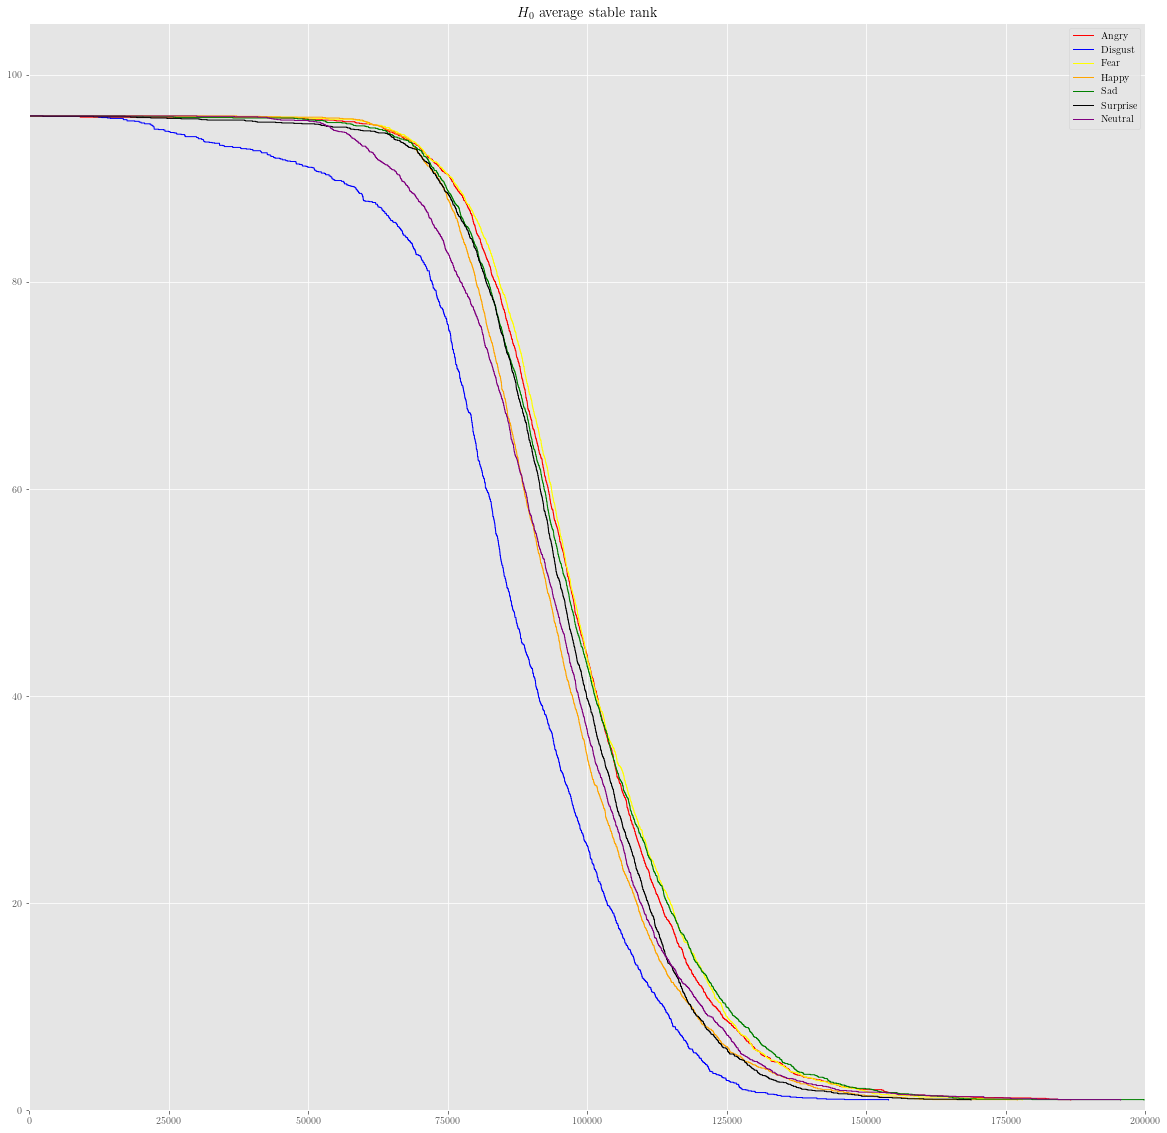

In [37]:
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
emotion_categories = [0,1,2,3,4,5,6]
emotion_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
colours=["red","blue","yellow","orange","green","black","purple"]
legends = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# specifying the number of pictures for subsampling
number_of_pictures = 100 # How many pictures per subsampling
number_of_times = 25 # How often to perform subsampling for each emotion

# specifying metric
metric = "cityblock"
metric_parameter = 100

# specifying clustering method
clustering_method = "single"

plt.figure(figsize=(20,20))

for e in emotion_categories:
    pos = np.array(np.where(df["emotion"]==e))[0]
    rand_pos = pos[list(np.random.permutation(np.arange(0,len(pos)-1))[:number_of_pictures])]

    # Preparing an empty array to convert the pixel vectors from string to float
    points_dummy = np.empty((len(rand_pos),48*48), int)

    for i in range(0,len(rand_pos)):
        points_dummy[i] = [int(numeric_string) for numeric_string in df[" pixels"][rand_pos[i]].split(' ')]

    # Create the point cloud
    points = np.vstack(points_dummy)
    point_cloud = sr.EucObject(points)

    # Add the pcf to the overall pcf but weighted to get the overall average in the end
    f_pcf = point_cloud.get_h0sr(metric = metric, metric_parameter = metric_parameter)*(1/number_of_times)
    
    for k in range(2,number_of_times):
        # Subsampling the positions
        pos = np.array(np.where(df["emotion"]==e))[0]
        rand_pos = pos[list(np.random.permutation(np.arange(0,len(pos)-1))[:number_of_pictures])]

        # Preparing an empty array to convert the pixel vectors from string to float
        points_dummy = np.empty((len(rand_pos),48*48), int)

        for i in range(0,len(rand_pos)):
            points_dummy[i] = [int(numeric_string) for numeric_string in df[" pixels"][rand_pos[i]].split(' ')]

        # Create the point cloud
        points = np.vstack(points_dummy)
        point_cloud = sr.EucObject(points)

        # Add the pcf to the overall pcf but weighted to get the overall average in the end
        f_pcf = f_pcf + point_cloud.get_h0sr(metric = metric, metric_parameter = metric_parameter)*(1/number_of_times)
    
    # plot the average pcf
    f_pcf.plot(color=colours[emotion_categories.index(e)])

    #print("size: ", point_cloud.size)
    #print("dimension: ", point_cloud.dim)
    #print("points: ", point_cloud.points)
plt.legend(legends)
#plt.ylabel('number of pictures')
plt.xlim([0,200000])
plt.ylim([0,105])
plt.title('$H_0$ average stable rank')
plt.savefig("H0stablerankaverage_embedding1.pdf")
os.system('pdfcrop %s %s' % ("H0stablerankaverage_embedding1.pdf", "H0stablerankaverage_embedding1.pdf"))
plt.show()

## $H_1$ stable rank for embedding 1

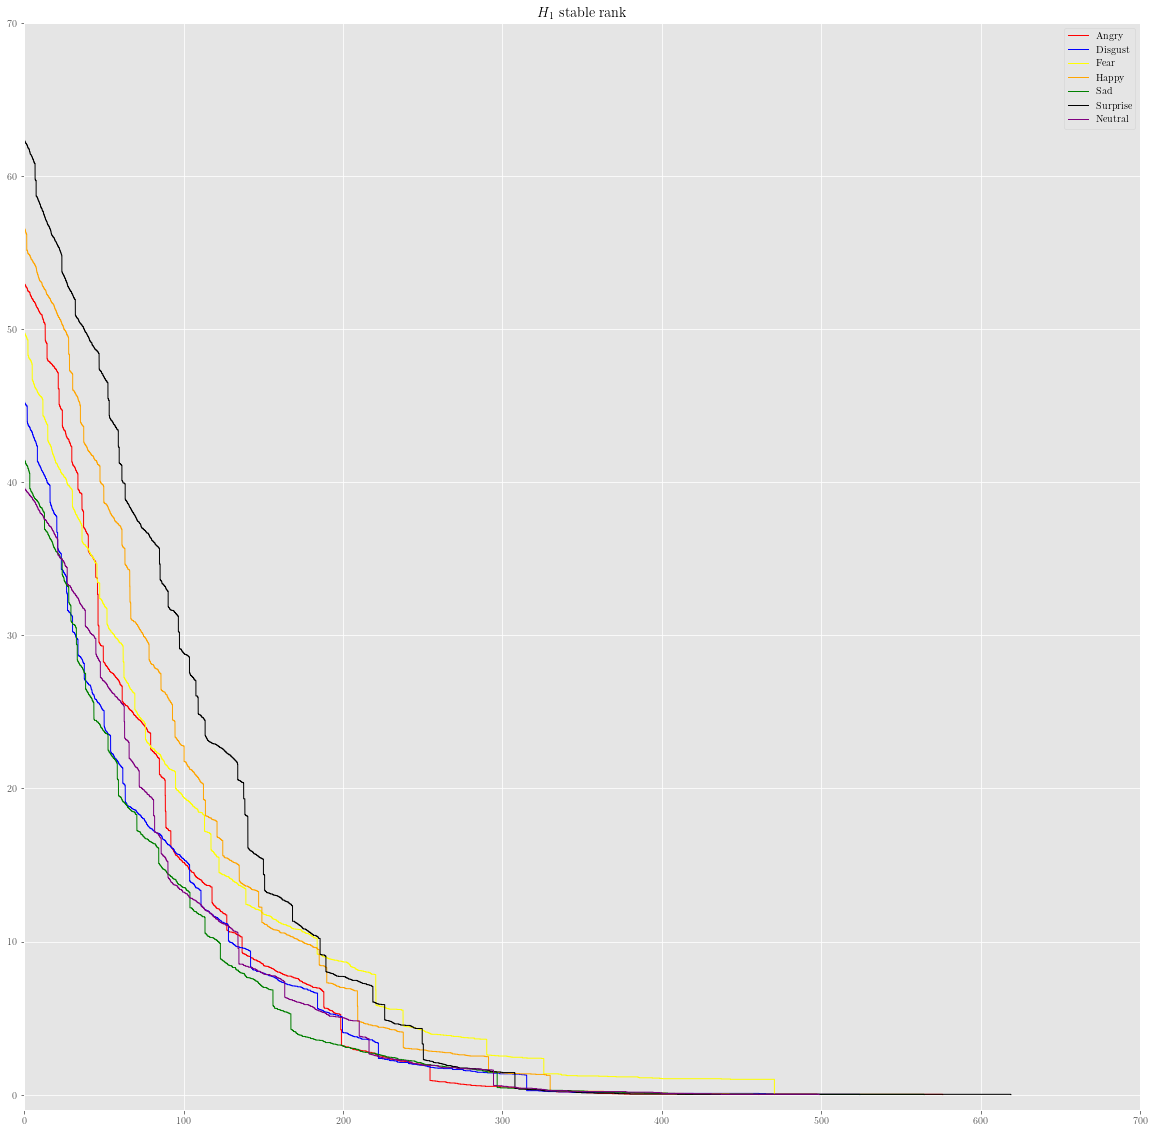

In [66]:
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
emotion_categories = [0,1,2,3,4,5,6]
emotion_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
colours=["red","blue","yellow","orange","green","black","purple"]
legends = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# specifying which homology
degree="H1"
md=1

# specifying the number of pictures for subsampling
number_of_pictures = 100 # How many pictures per subsampling
number_of_times = 50 # How often to perform subsampling for each emotion

# specifying metric
metric = "cityblock"#"euclidean"
metric_parameter = 3

# specifying clustering method
clustering_method = "single"

plt.figure(figsize=(20,20))

for e in emotion_categories:
    pos = np.array(np.where(df["emotion"]==e))[0]
    rand_pos = pos[list(np.random.permutation(np.arange(0,len(pos)-1))[:number_of_pictures])]

    # Preparing an empty array to convert the pixel vectors from string to float
    points_dummy = np.empty((len(rand_pos),48*48), int)

    for i in range(0,len(rand_pos)):
        points_dummy[i] = [int(numeric_string) for numeric_string in df[" pixels"][rand_pos[i]].split(' ')]

    # Create the point cloud
    points = np.vstack(points_dummy)
    point_cloud = sr.EucObject(points)

    # Add the pcf to the overall pcf but weighted to get the overall average in the end
    b = point_cloud.get_bc(maxdim=md)
    f_pcf = sr.bc_to_sr(b, degree)
    
    for k in range(2,number_of_times):
        # Subsampling the positions
        pos = np.array(np.where(df["emotion"]==e))[0]
        rand_pos = pos[list(np.random.permutation(np.arange(0,len(pos)-1))[:number_of_pictures])]

        # Preparing an empty array to convert the pixel vectors from string to float
        points_dummy = np.empty((len(rand_pos),48*48), int)

        for i in range(0,len(rand_pos)):
            points_dummy[i] = [int(numeric_string) for numeric_string in df[" pixels"][rand_pos[i]].split(' ')]

        # Create the point cloud
        points = np.vstack(points_dummy)
        point_cloud = sr.EucObject(points)

        # Add the pcf to the overall pcf but weighted to get the overall average in the end
        b = point_cloud.get_bc(maxdim=md)
        f_pcf = f_pcf + sr.bc_to_sr(b, degree)*(1/number_of_times)
    
    # plot the average pcf
    f_pcf.plot(color=colours[emotion_categories.index(e)])

    #print("size: ", point_cloud.size)
    #print("dimension: ", point_cloud.dim)
    #print("points: ", point_cloud.points)
plt.legend(legends)
plt.xlim([0,700])
plt.ylim([-1,70])
plt.title('$H_1$ stable rank')
plt.savefig("H1stablerank_embedding1.pdf")
os.system('pdfcrop %s %s' % ("H1stablerank_embedding1.pdf", "H1stablerank_embedding1.pdf"))
plt.show()

## $H_1$ stable rank average embedding 1

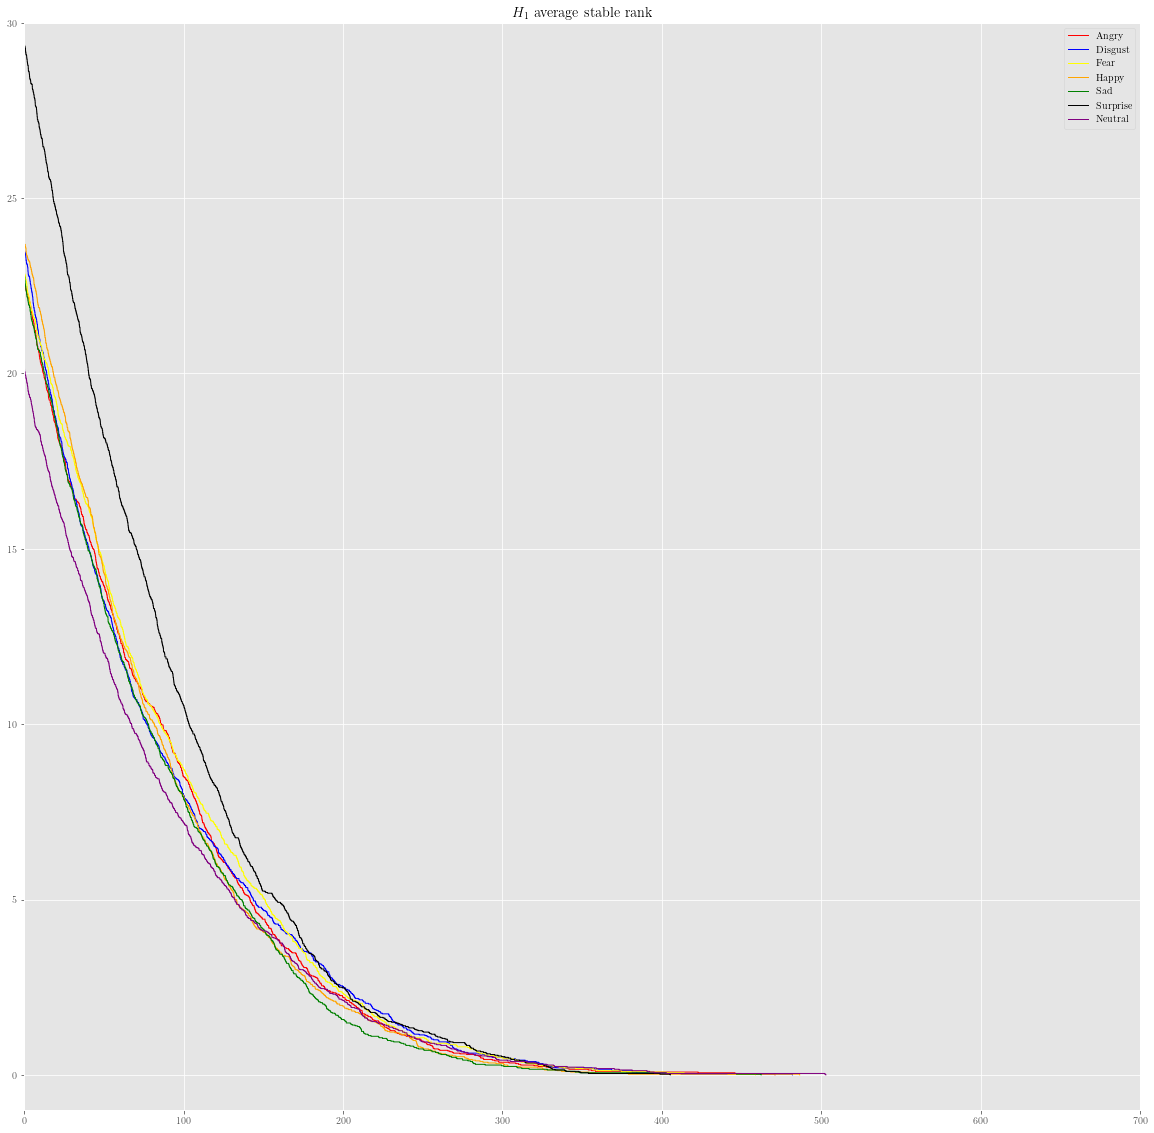

In [49]:
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
emotion_categories = [0,1,2,3,4,5,6]
emotion_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
colours=["red","blue","yellow","orange","green","black","purple"]
legends = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# specifying which homology
degree="H1"
md=1

# specifying the number of pictures for subsampling
number_of_pictures = 100 # How many pictures per subsampling
number_of_times = 50 # How often to perform subsampling for each emotion

# specifying metric
metric = "euclidean"
metric_parameter = 3

# specifying clustering method
clustering_method = "single"

plt.figure(figsize=(20,20))

for e in emotion_categories:
    pos = np.array(np.where(df["emotion"]==e))[0]
    rand_pos = pos[list(np.random.permutation(np.arange(0,len(pos)-1))[:number_of_pictures])]

    # Preparing an empty array to convert the pixel vectors from string to float
    points_dummy = np.empty((len(rand_pos),48*48), int)

    for i in range(0,len(rand_pos)):
        points_dummy[i] = [int(numeric_string) for numeric_string in df[" pixels"][rand_pos[i]].split(' ')]

    # Create the point cloud
    points = np.vstack(points_dummy)
    point_cloud = sr.EucObject(points)

    # Add the pcf to the overall pcf but weighted to get the overall average in the end
    b = point_cloud.get_bc(maxdim=md)
    f_pcf = sr.bc_to_sr(b, degree)*(1/number_of_times)
    
    for k in range(2,number_of_times):
        # Subsampling the positions
        pos = np.array(np.where(df["emotion"]==e))[0]
        rand_pos = pos[list(np.random.permutation(np.arange(0,len(pos)-1))[:number_of_pictures])]

        # Preparing an empty array to convert the pixel vectors from string to float
        points_dummy = np.empty((len(rand_pos),48*48), int)

        for i in range(0,len(rand_pos)):
            points_dummy[i] = [int(numeric_string) for numeric_string in df[" pixels"][rand_pos[i]].split(' ')]

        # Create the point cloud
        points = np.vstack(points_dummy)
        point_cloud = sr.EucObject(points)

        # Add the pcf to the overall pcf but weighted to get the overall average in the end
        b = point_cloud.get_bc(maxdim=md)
        f_pcf = f_pcf + sr.bc_to_sr(b, degree)*(1/number_of_times)
    
    # plot the average pcf
    f_pcf.plot(color=colours[emotion_categories.index(e)])

    #print("size: ", point_cloud.size)
    #print("dimension: ", point_cloud.dim)
    #print("points: ", point_cloud.points)
plt.legend(legends)
plt.xlim([0,700])
plt.ylim([-1,30])
plt.title('$H_1$ average stable rank')
plt.savefig("H1stablerankaverage_embedding1.pdf")
os.system('pdfcrop %s %s' % ("H1stablerankaverage_embedding1.pdf", "H1stablerankaverage_embedding1.pdf"))
plt.show()

# Dendrogram from embedding 1

In [68]:
def big_list(T):
    L=[]
    for i in range(len(T)):
        L=L+list(T[i])
    return L

array([200, 123, 135, ...,   4,   4,   4])

array([155, 175, 145, ...,  56,  30,  22])

array([207, 251, 174, ...,  83,  54,  95])

array([ 79,  92,  97, ..., 188,  89, 100])

array([103, 107, 113, ..., 172, 188, 192])

array([ 50,  50,  51, ..., 202, 200, 195])

array([ 24,  22,  27, ..., 133,  92, 163])

[[200 123 135 ...   4   4   4]
 [155 175 145 ...  56  30  22]
 [207 251 174 ...  83  54  95]
 ...
 [103 107 113 ... 172 188 192]
 [ 50  50  51 ... 202 200 195]
 [ 24  22  27 ... 133  92 163]]


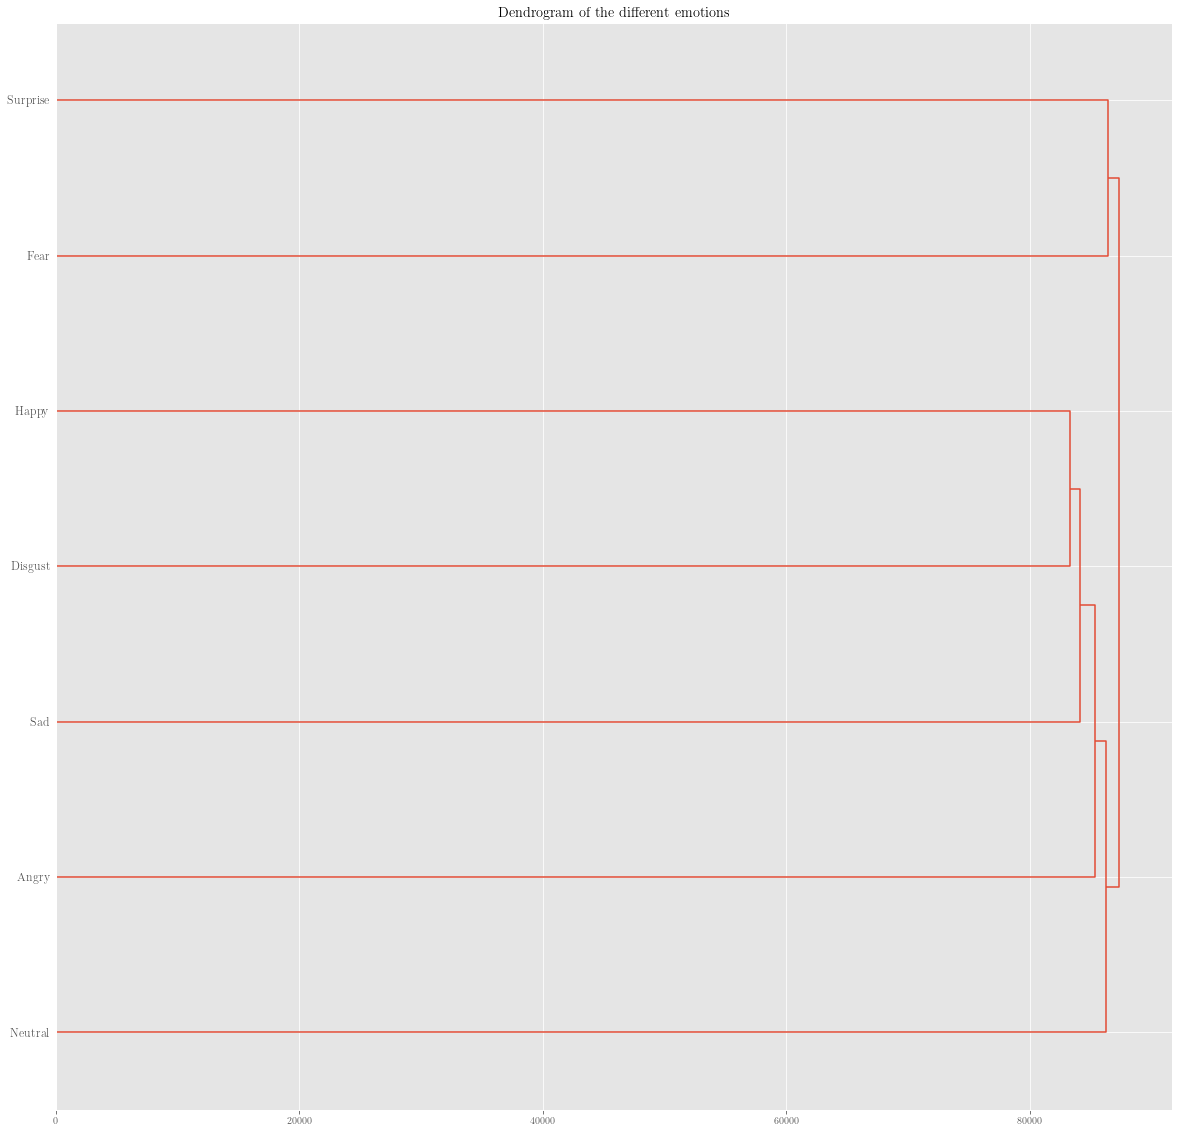

In [91]:
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
emotion_categories = [0,1,2,3,4,5,6]
#colours=["red","blue","yellow","orange","green","black","purple"]
legends = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# specifying the number of pictures for subsampling
number_of_pictures = 400
number_of_times = 50 # How often to perform subsampling for each emotion

plt.figure(figsize=(20,20))

#points = np.array([])
points=[]
for e in emotion_categories:
    pos = np.array(np.where(df["emotion"]==e))[0]
    #rand_pos = pos[np.random.randint(0,len(pos)-1,number_of_pictures)]
    rand_pos = pos[list(np.random.permutation(np.arange(0,len(pos)-1))[:number_of_pictures])]
    points_dummy = np.empty((len(rand_pos),48*48), int)

    for i in range(0,len(rand_pos)):
        points_dummy[i] = [int(numeric_string) for numeric_string in df[" pixels"][rand_pos[i]].split(' ')]
    
    points_stack = big_list(points_dummy)
    points.append(points_stack)
    display(np.hstack(points_stack))
    
print(np.array(points))
Z = hierarchy.linkage(points, 'average')
hierarchy.dendrogram(Z, orientation = 'right', labels = legends)
#hierarchy.set_link_color_palette(["red","blue","yellow","orange","green","black","purple"])
plt.title('Dendrogram of the different emotions')
plt.savefig("dendrogram.pdf")
os.system('pdfcrop %s %s' % ("dendrogram.pdf", "dendrogram.pdf"))
plt.show()

## Barecodes on different emotions

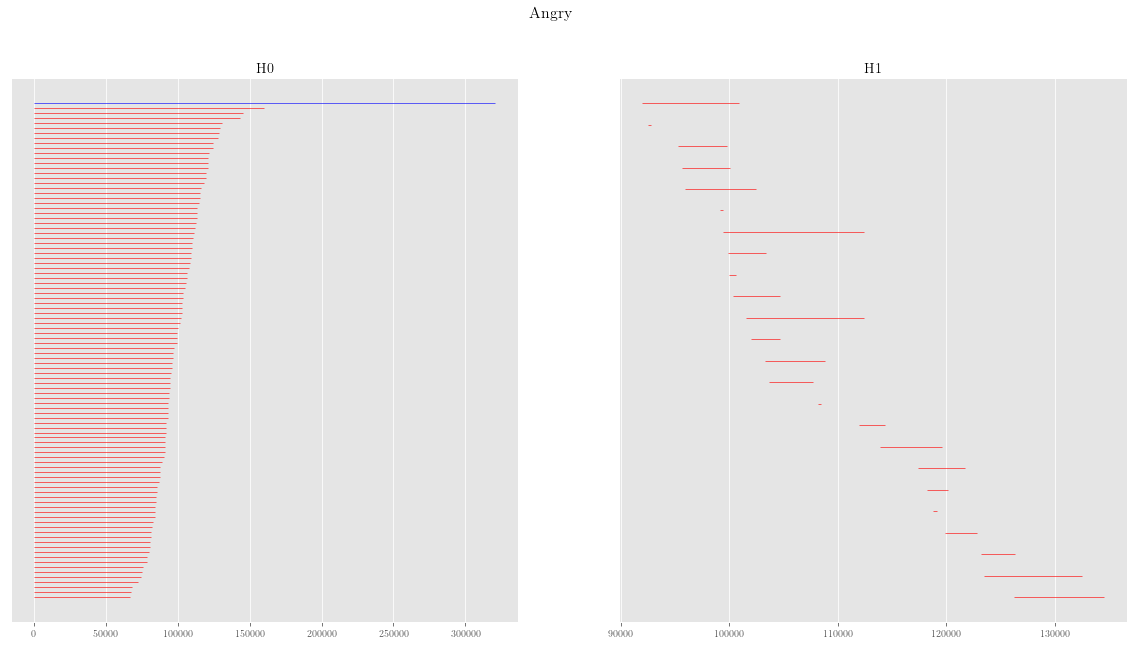

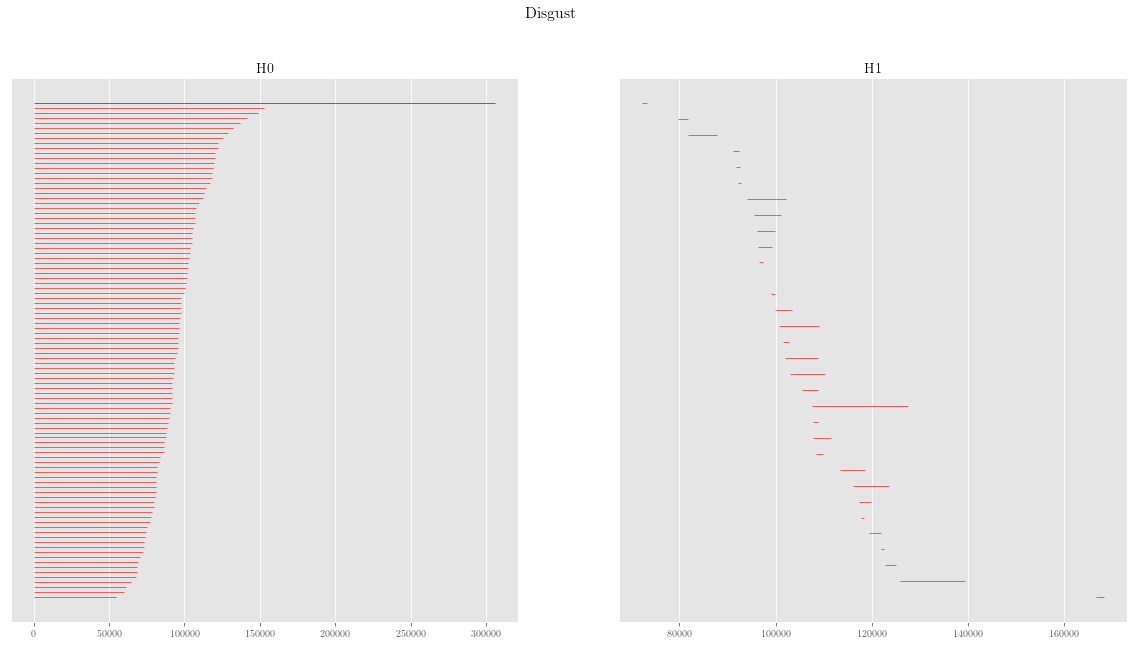

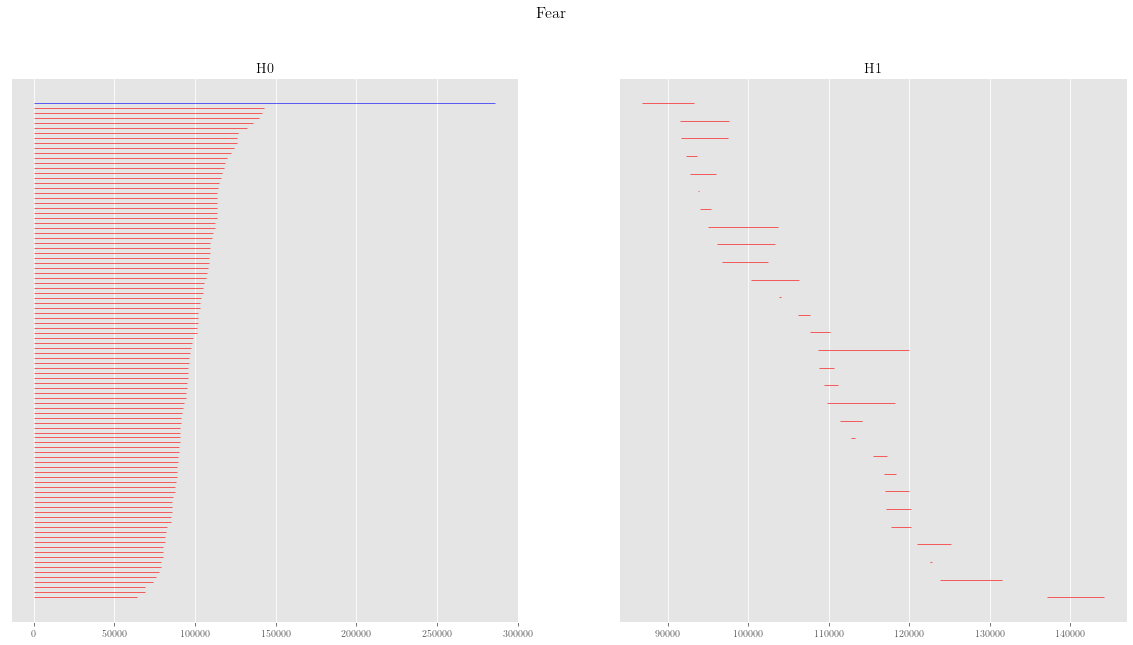

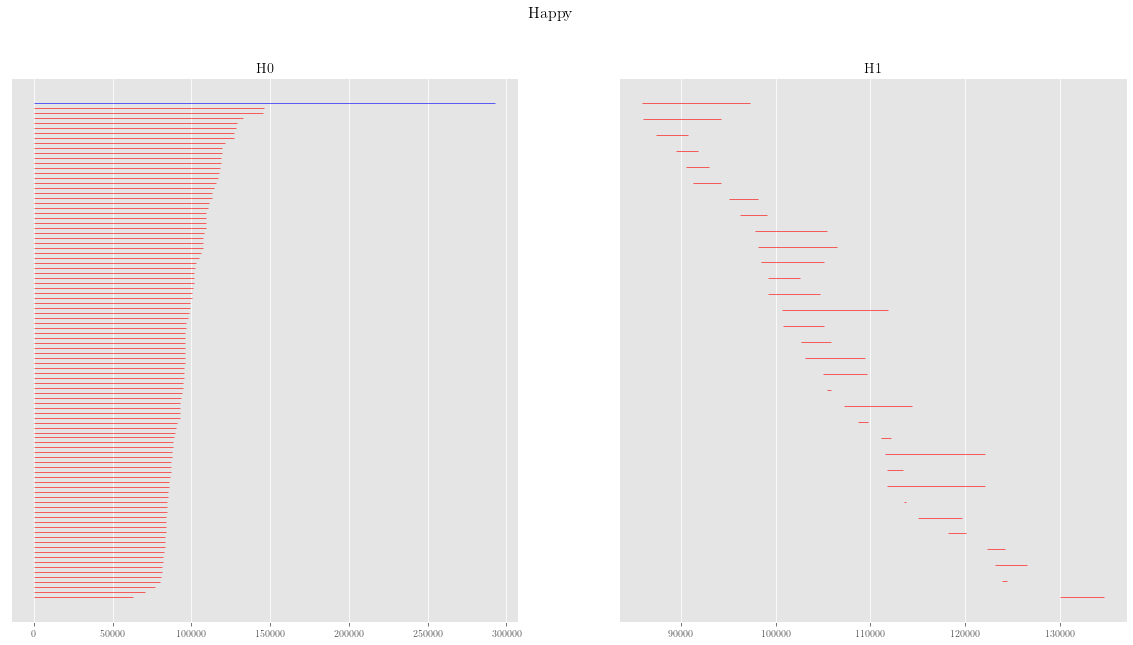

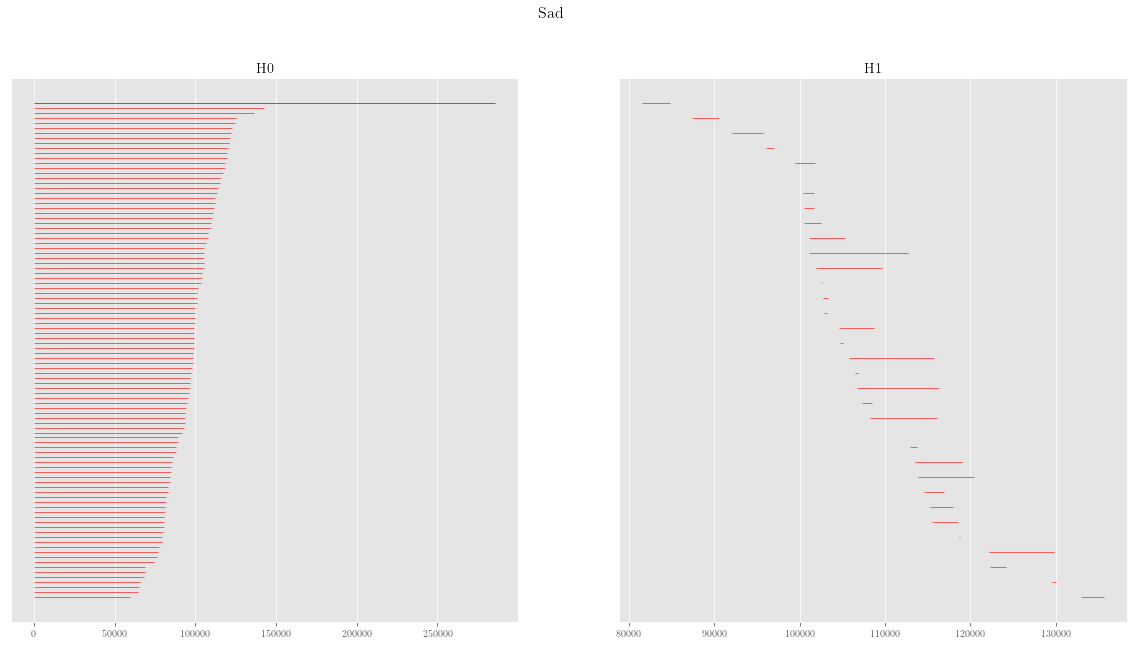

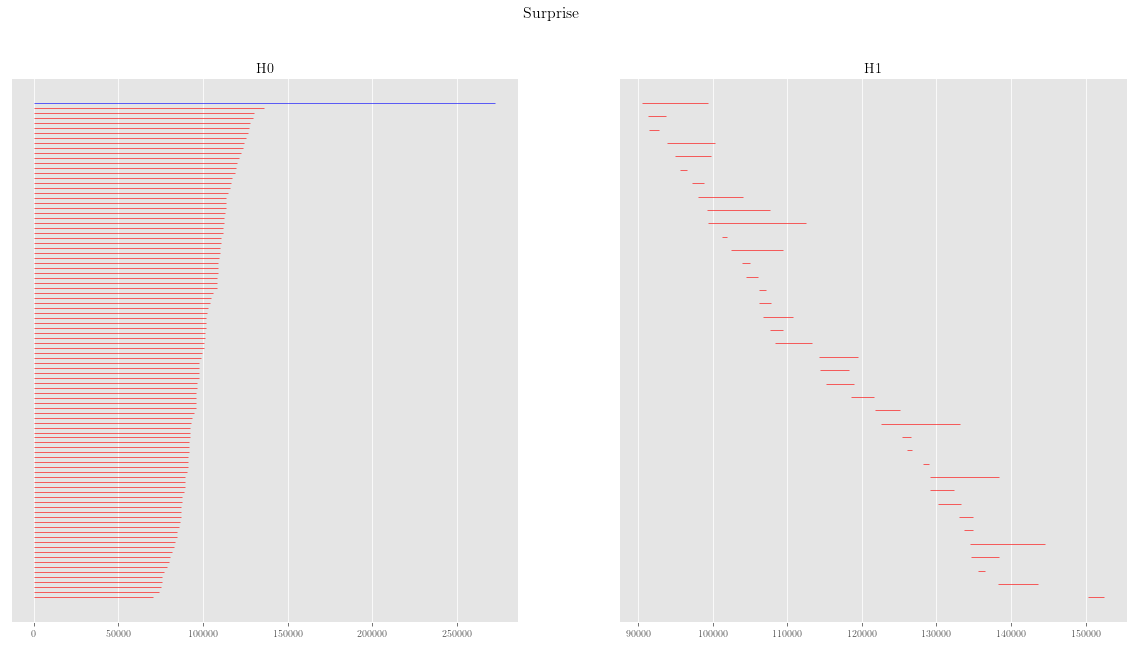

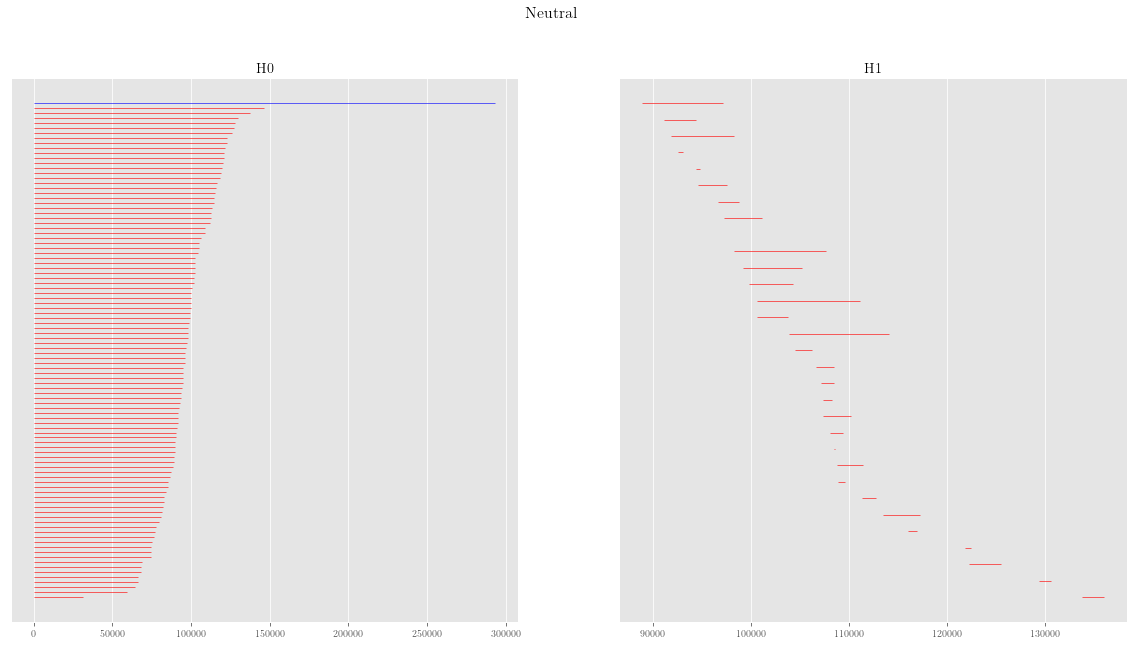

In [82]:
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
emotion_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
emotion_categories = [0,1,2,3,4,5,6]
#metrics = ["euclidean"]
metrics = ["cityblock"]
for e in emotion_categories:
    pos = np.array(np.where(df["emotion"]==0))[0]
    rand_pos = pos[list(np.random.permutation(np.arange(0,len(pos)-1))[:100])]
    points_dummy = np.empty((len(rand_pos),48*48), int)

    for i in range(0,len(rand_pos)):
        points_dummy[i] = [int(numeric_string) for numeric_string in df[" pixels"][rand_pos[i]].split(' ')]

    points = np.vstack(points_dummy)
    em = sr.EucObject(points)


    D ={}
    for m in metrics:
        D[m] = em.get_distance(metric = m)

    maxdim = 3
    coeff = 2

    bc = D[m].get_bc(maxdim = maxdim, coeff = coeff)
    fig=plt.figure(emotion_names[e], figsize = (20,10))
    fig.suptitle(emotion_names[e], fontsize=16)
    ax=plt.subplot(1,2,1)
    ax.set_title("H0")
    bc["H0"].plot()
    ax=plt.subplot(1,2,2)
    ax.set_title("H1")
    bc["H1"].plot()
#plt.savefig("barecode.pdf")
#os.system('pdfcrop %s %s' % ("barecode.pdf", "barecode.pdf"))
#plt.show()

## $H_0$ stable rank embedding 2

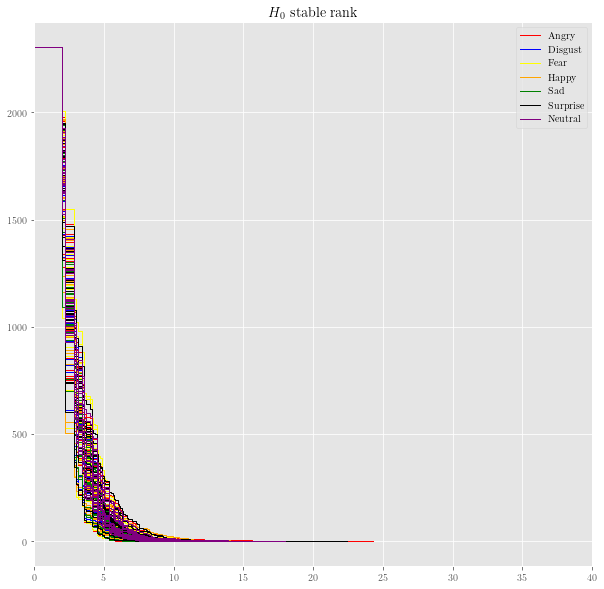

In [150]:
emotion_categories = [0,1,2,3,4,5,6]
#emotion_categories = [1,2,4]
emotion_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
colours=["red","blue","yellow","orange","green","black","purple"]
legends = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# specifying the number of pictures for subsampling
number_of_pictures = 25# How many pictures per subsampling

# specifying metric
metric = "euclidean"
metric_parameter = 100

# specifying clustering method
clustering_method = "single"

#fig, ax = plt.subplots()
plt.figure(figsize=(10,10))

for e in emotion_categories:
    pos = np.array(np.where(df["emotion"]==e))[0]
    rand_pos = pos[list(np.random.permutation(np.arange(0,len(pos)-1))[:number_of_pictures])]
    #rand_pos=pos
    
    # Calculate euclidean object for the first image
    pixel_values_1 = [int(numeric_string) for numeric_string in df[" pixels"][rand_pos[0]].split(' ')]
    
    image_dummy_1 = np.empty((48*48,3), int)
    
    for i in range(0,len(image_dummy_1)):
        # Try out different normalizations:
        # No normalization
        # image_dummy_1[i] = [(i-i%48)/48, i%48, pixel_values_1[i]/255]
        # Normalization
        # image_dummy_1[i] = [(i-i%48)/48, i%48, 47*pixel_values_1[i]/255]
        # Fully normalized
        # image_dummy_1[i] = [((i-i%48)/48)/47, (i%48)/47, pixel_values_1[i]/255]
        
        # Working best: All values between 0 and 100
        image_dummy_1[i] = [(100/47)*(i-i%48)/48, (100/47)*(i%48), (100/47)*(47*pixel_values_1[i]/255)]
        
    image_stacked_1 = np.vstack(image_dummy_1)
    image_1 = sr.EucObject(image_stacked_1)
    
    # Add the pcf to the overall pcf but weighted to get the overall average in the end
    f = image_1.get_h0sr(metric = metric, metric_parameter = metric_parameter)*(1/number_of_pictures)
    
    
    # Calculate stable rank for the remaining images
    for p in range(1,number_of_pictures):
        
        pixel_values_i = [int(numeric_string) for numeric_string in df[" pixels"][rand_pos[p]].split(' ')]
        image_dummy_i = np.empty((48*48,3), int)
        
        for i in range(0,len(image_dummy_i)):
            image_dummy_i[i] = [(100/47)*(i-i%48)/48, (100/47)*(i%48), (100/47)*(47*pixel_values_i[i]/255)]
            
        image_stacked_i = np.vstack(image_dummy_i)
        image_i = sr.EucObject(image_stacked_i)
        
        # Add the pcf to the overall pcf but weighted to get the overall average in the end
        # f = f + image_i.get_h0sr(metric = metric, metric_parameter = metric_parameter)*(1/number_of_pictures)
        
        # Plot single pcf
        f = image_i.get_h0sr(metric = metric, metric_parameter = metric_parameter)
        f.plot(color=colours[emotion_categories.index(e)])
        #ax.legend(legends)
    # plot the average pcf
    #f.plot(color=colours[emotion_categories.index(e)])
plt.xlim([0,40])
leg = plt.legend(legends)
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('blue')
leg.legendHandles[2].set_color('yellow')
leg.legendHandles[3].set_color('orange')
leg.legendHandles[4].set_color('green')
leg.legendHandles[5].set_color('black')
leg.legendHandles[6].set_color('purple')
plt.title('$H_0$ stable rank')
plt.savefig("stable_rank_embedding2.pdf")
os.system('pdfcrop %s %s' % ("stable_rank_embedding2.pdf", "stable_rank_embedding2.pdf"))
plt.show()

## $H_1$ stable rank embedding 2

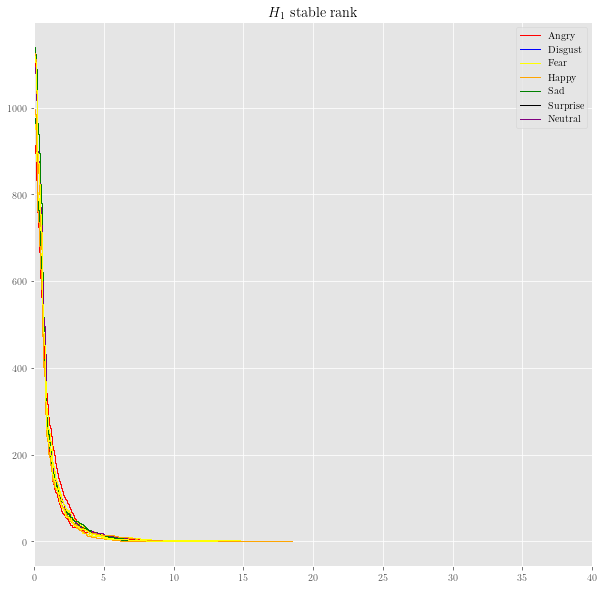

In [149]:
# number of stable ranks to plot 
k=10

# select homology and maxdim
degree="H1"
md=1

# colorcode emotions
emotion_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
colors=["red","blue","yellow","orange","green","black","purple"]
legends = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

plt.figure(figsize=(10,10))

for u in range(0,k):
    pixel_values_it = [int(numeric_string) for numeric_string in df[" pixels"][u].split(' ')]

    image_dummy_it = np.empty((48*48,3), int)
    for i in range(0,len(image_dummy_it)):
        image_dummy_it[i] = [(100/47)*(i-i%48)/48, (100/47)*(i%48), (100/47)*(47*pixel_values_it[i]/255)]

    image_stacked_it = np.vstack(image_dummy_it)
    image_it = sr.EucObject(image_stacked_it)
    
    b_it = image_it.get_bc(maxdim=md)
    S_it = sr.bc_to_sr(b_it, degree)
    
    # get which emotion is expressed on the image
    emotion = int(df["emotion"][u])
    
    S_it.plot(color = colors[emotion])

plt.xlim([0,40])
leg = plt.legend(legends)
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('blue')
leg.legendHandles[2].set_color('yellow')
leg.legendHandles[3].set_color('orange')
leg.legendHandles[4].set_color('green')
leg.legendHandles[5].set_color('black')
leg.legendHandles[6].set_color('purple')
plt.title('$H_1$ stable rank')
plt.savefig("H1stable_rank_embedding2.pdf")
os.system('pdfcrop %s %s' % ("H1stable_rank_embedding2.pdf", "H1stable_rank_embedding2.pdf"))
plt.show()